# CART

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import numpy as np
import pandas as pd

from preprocess import data

np.random.seed(0)


In [10]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"][1:].reset_index(drop=True)
y_austria = data["y_austria"][1:].reset_index(drop=True)

x_germany = pd.concat([x_germany, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])
x_austria = pd.concat([x_austria, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])

## Experiments

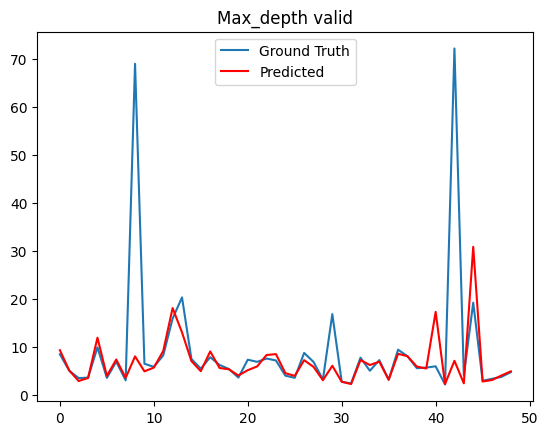

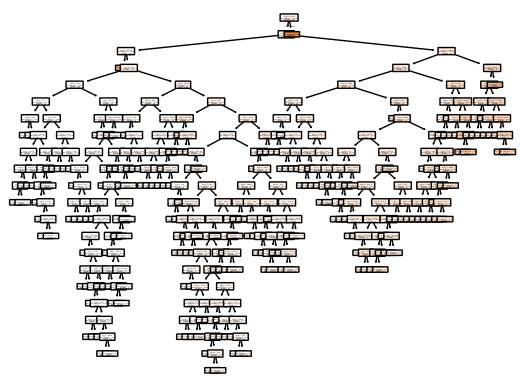

In [52]:
# Classical Train/Valid max depth

X_train, X_valid, y_train, y_valid = train_test_split(X_ger, y_ger, test_size=0.2, random_state=0)

max_depth = None  # Aucun maximum de profondeur pour un arbre maximal
regressor = DecisionTreeRegressor(max_depth=max_depth)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_valid)


plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Max_depth valid')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

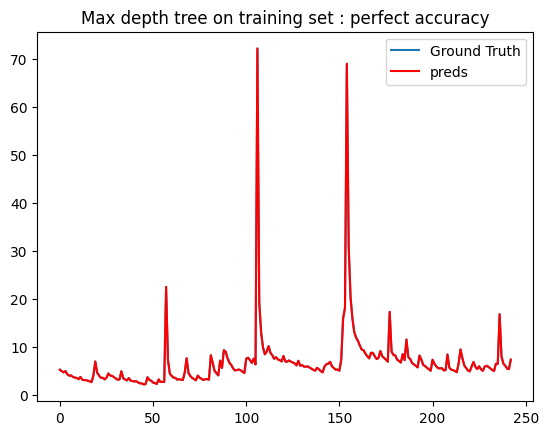

In [53]:
#Max Depth without train / valid split 

X_train = X_ger
y_train = y_ger

max_depth = None  
regressor = DecisionTreeRegressor(max_depth=max_depth)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_train)

plt.plot(y_train.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Max depth tree on training set : perfect accuracy')
plt.legend()
plt.show()

## K-folds on max_depth (no pruning)

Profondeur optimale: 3


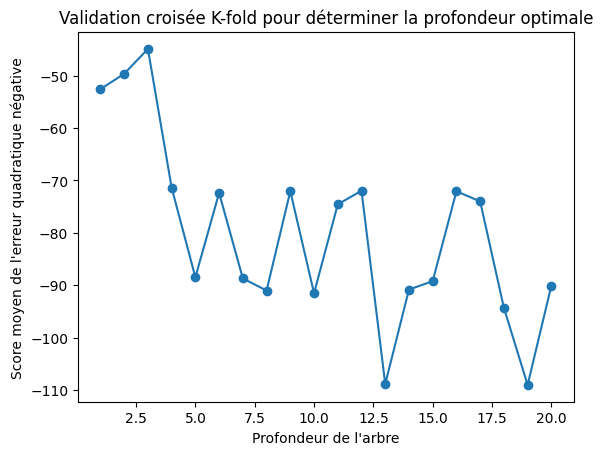

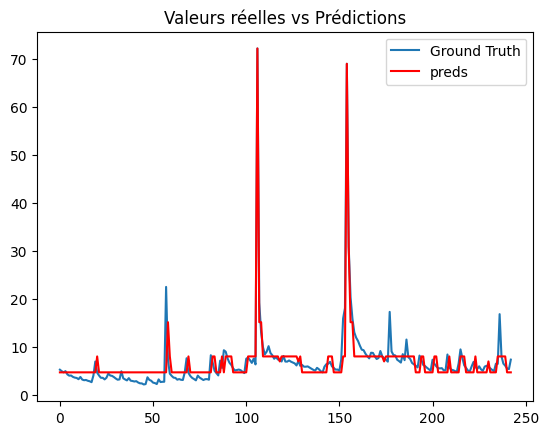

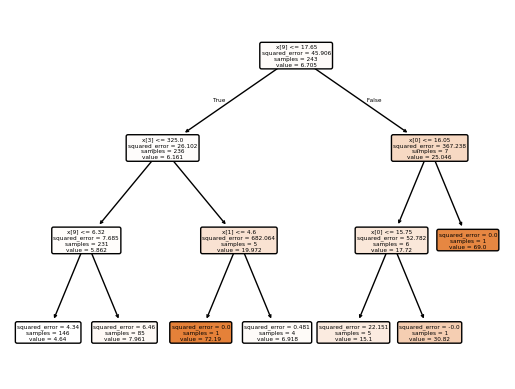

In [44]:
# Without train test split
X, y = x_germany, y_germany


# kf = KFold(n_splits=5, shuffle=True, random_state=0)
depths = range(1, 21)
mean_scores = []

for depth in depths:
    regressor = DecisionTreeRegressor(max_depth=depth)
    scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))

optimal_depth = depths[np.argmax(mean_scores)]
print(f'Profondeur optimale: {optimal_depth}')

plt.plot(depths, mean_scores, marker='o')
plt.xlabel('Profondeur de l\'arbre')
plt.ylabel('Score moyen de l\'erreur quadratique négative')
plt.title('Validation croisée K-fold pour déterminer la profondeur optimale')
plt.show()

regressor = DecisionTreeRegressor(max_depth=optimal_depth)
regressor.fit(X, y)
y_pred = regressor.predict(X)


plt.plot(y.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Valeurs réelles vs Prédictions')
plt.legend()
plt.show()

plot_tree(regressor, filled=True, rounded=True)
plt.show()

In [40]:
from eval import MAE
MAE(y_pred,y_germany)

ValueError: operands could not be broadcast together with shapes (243,) (49,) 

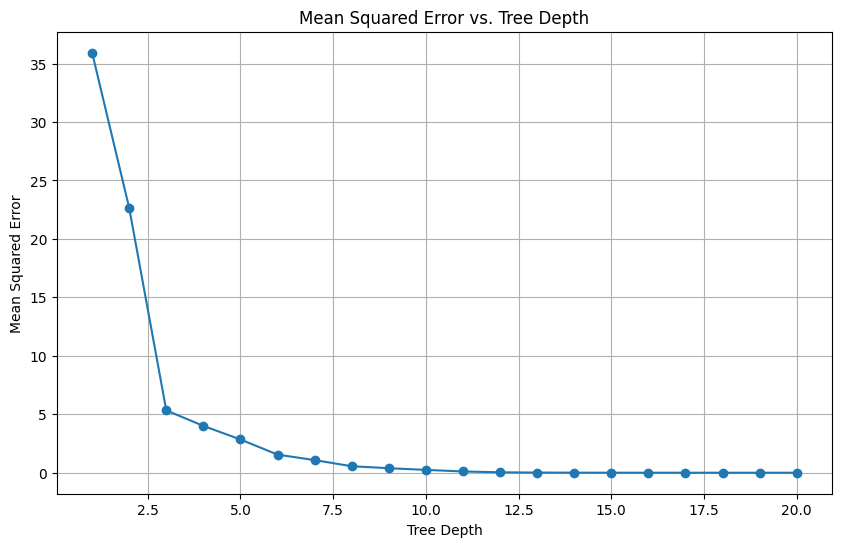

In [37]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X_train and y_train are your training data
# Replace these with your actual data
X_train = x_germany
y_train = y_germany

# Define the range of depths to test
depths = range(1, 21)

# Initialize lists to store the depths and corresponding errors
errors = []

# Loop over the range of depths
for depth in depths:
    # Train the model with the current depth
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    
    # Predict on the training set
    y_pred = model.predict(X_train)
    
    # Calculate the mean squared error
    error = mean_squared_error(y_train, y_pred)
    
    # Append the error to the list
    errors.append(error)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(depths, errors, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Tree Depth')
plt.grid(True)
plt.show()

## K-folds on max_depth with pruning 

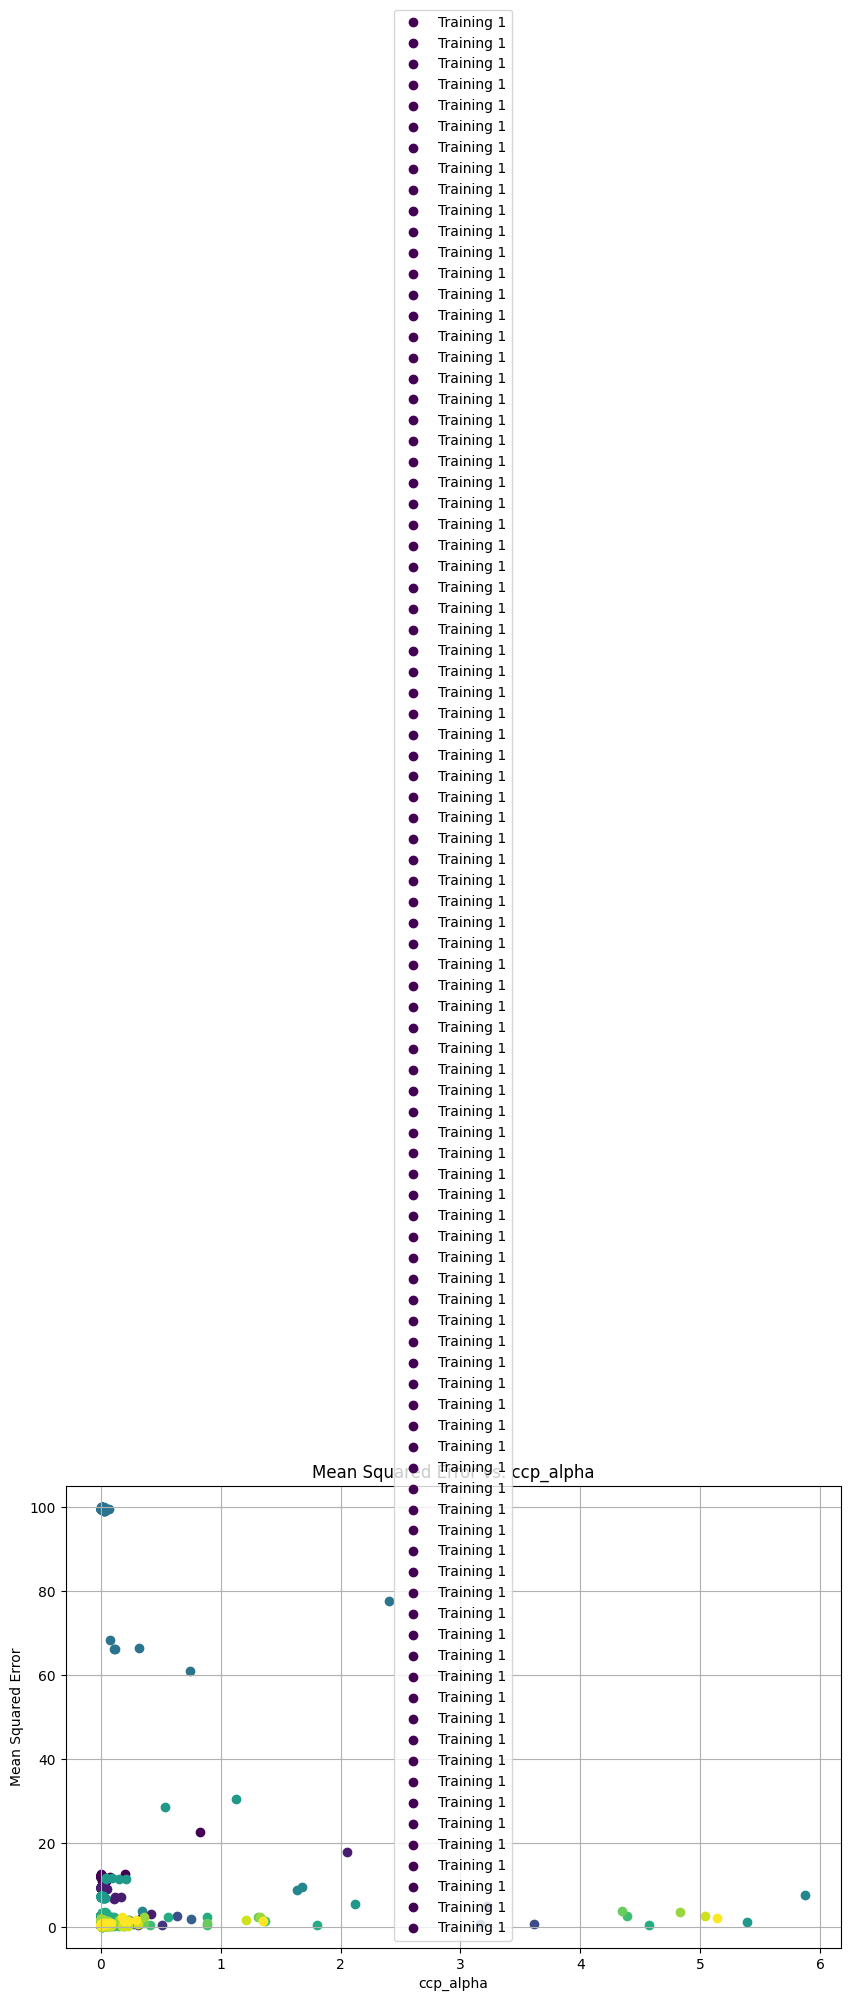

The best ccp_alpha is 0.007310100000001861 with a mean squared error of 0.05098894969135809


In [57]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train and y_train are your training data
# Replace these with your actual data
X_train = x_austria
y_train = y_austria

# Define the number of samples for training and validation
train_size = 100
validation_size = 10

# Initialize lists to store the alphas and corresponding errors
ccp_alphas = []
errors = []

# Define a color map
colors = plt.cm.viridis(np.linspace(0, 1, (len(X_train) - train_size - validation_size) // validation_size + 1))

# Loop over the dataset in chunks
for i, start in enumerate(range(0, len(X_train) - train_size - validation_size + 1, validation_size)):
    # Define the training and validation sets
    X_train_subset = X_train[start:start + train_size]
    y_train_subset = y_train[start:start + train_size]
    X_validation = X_train[start + train_size:start + train_size + validation_size]
    y_validation = y_train[start + train_size:start + train_size + validation_size]
    
    # Train a DecisionTreeRegressor to get the ccp_alphas
    model = DecisionTreeRegressor(random_state=0)
    path = model.cost_complexity_pruning_path(X_train_subset, y_train_subset)
    ccp_alphas.extend(path.ccp_alphas)
    
    # Loop over the range of ccp_alphas
    for ccp_alpha in path.ccp_alphas:
        # Train the model with the current ccp_alpha
        model = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
        model.fit(X_train_subset, y_train_subset)
        
        # Predict on the validation set
        y_pred = model.predict(X_validation)
        
        # Calculate the mean squared error
        error = mean_squared_error(y_validation, y_pred)
        
        # Append the error to the list
        errors.append((ccp_alpha, error, i))

# Aggregate errors by ccp_alpha
ccp_alpha_errors = {}
for ccp_alpha, error, i in errors:
    if ccp_alpha not in ccp_alpha_errors:
        ccp_alpha_errors[ccp_alpha] = []
    ccp_alpha_errors[ccp_alpha].append((error, i))

# Calculate the mean error for each ccp_alpha
mean_errors = {ccp_alpha: np.mean([err for err, _ in errs]) for ccp_alpha, errs in ccp_alpha_errors.items()}

# Plot the curve
plt.figure(figsize=(10, 6))
for ccp_alpha, errs in ccp_alpha_errors.items():
    for error, i in errs:
        plt.scatter(ccp_alpha, error, color=colors[i], label=f'Training {i+1}' if i == 0 else "")

plt.xlabel('ccp_alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. ccp_alpha')
plt.grid(True)
plt.legend()
plt.show()

# Find the best ccp_alpha
best_ccp_alpha = min(mean_errors, key=mean_errors.get)
best_error = mean_errors[best_ccp_alpha]

print(f'The best ccp_alpha is {best_ccp_alpha} with a mean squared error of {best_error}')

In [54]:
ccp_alphas

[0.0,
 4.999999999988348e-07,
 5.000000000077166e-07,
 5.000000000165983e-07,
 5.000000000165983e-07,
 5.000000000876525e-07,
 5.000000001409432e-07,
 1.9999999998887574e-06,
 1.9999999999953387e-06,
 1.9999999999953387e-06,
 2.0000000000131022e-06,
 2.0000000000131022e-06,
 2.0000000001729746e-06,
 2.00000000035061e-06,
 4.166666666680641e-06,
 4.1666666666984035e-06,
 4.499999999989513e-06,
 7.99999999985701e-06,
 7.999999999999119e-06,
 8.166666666689082e-06,
 1.066666666670102e-05,
 1.2500000000006396e-05,
 1.800000000001134e-05,
 2.450000000003172e-05,
 2.4500000000049483e-05,
 3.200000000000536e-05,
 3.203333333333447e-05,
 4.033333333341993e-05,
 4.049999999999443e-05,
 4.266666666659092e-05,
 4.9999999999990055e-05,
 5.000000000014992e-05,
 5.000000000027427e-05,
 5.624999999998437e-05,
 6.016666666674553e-05,
 6.0499999999947816e-05,
 7.679999999982812e-05,
 8.099999999991781e-05,
 8.333333333355952e-05,
 0.00010416666666666075,
 0.00011250000000002202,
 0.00011250000000011972

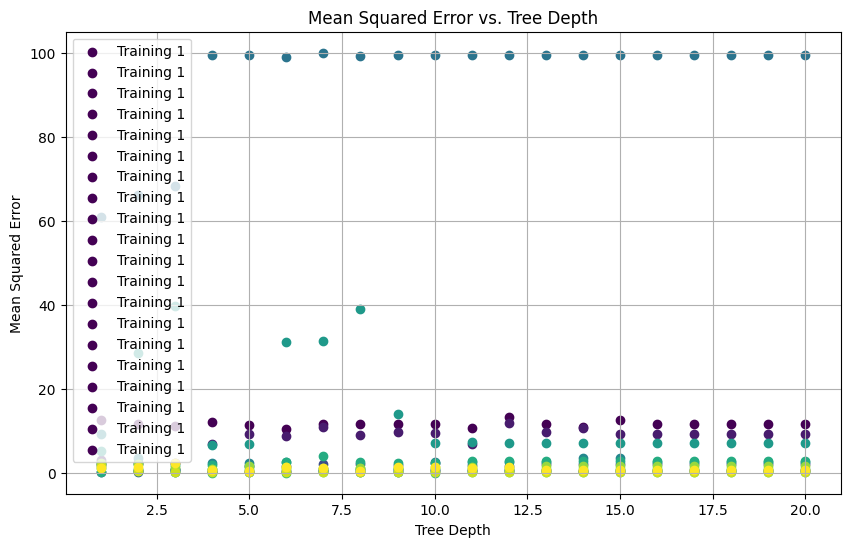

The best depth is 1 with a mean squared error of 7.504130297079089


In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train and y_train are your training data
# Replace these with your actual data
X_train = x_austria
y_train = y_austria

# Define the number of samples for training and validation
train_size = 100
validation_size = 10

# Define the range of depths to test
depths = range(1, 21)

# Initialize lists to store the depths and corresponding errors
errors = []

# Define a color map
colors = plt.cm.viridis(np.linspace(0, 1, (len(X_train) - train_size - validation_size) // validation_size + 1))

# Loop over the dataset in chunks
for i, start in enumerate(range(0, len(X_train) - train_size - validation_size + 1, validation_size)):
    # Define the training and validation sets
    X_train_subset = X_train[start:start + train_size]
    y_train_subset = y_train[start:start + train_size]
    X_validation = X_train[start + train_size:start + train_size + validation_size]
    y_validation = y_train[start + train_size:start + train_size + validation_size]
    
    # Loop over the range of depths
    for depth in depths:
        # Train the model with the current depth
        model = DecisionTreeRegressor(max_depth=depth, random_state=0)
        model.fit(X_train_subset, y_train_subset)
        
        # Predict on the validation set
        y_pred = model.predict(X_validation)
        
        # Calculate the mean squared error
        error = mean_squared_error(y_validation, y_pred)
        
        # Append the error to the list
        errors.append((depth, error, i))

# Aggregate errors by depth
depth_errors = {}
for depth, error, i in errors:
    if depth not in depth_errors:
        depth_errors[depth] = []
    depth_errors[depth].append((error, i))

# Calculate the mean error for each depth
mean_errors = {depth: np.mean([err for err, _ in errs]) for depth, errs in depth_errors.items()}

# Plot the curve
plt.figure(figsize=(10, 6))
for depth, errs in depth_errors.items():
    for error, i in errs:
        plt.scatter(depth, error, color=colors[i], label=f'Training {i+1}' if i == 0 else "")

plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Tree Depth')
plt.grid(True)
plt.legend()
plt.show()

# Find the best depth
best_depth = min(mean_errors, key=mean_errors.get)
best_error = mean_errors[best_depth]

print(f'The best depth is {best_depth} with a mean squared error of {best_error}')

## CART extending window no pruning

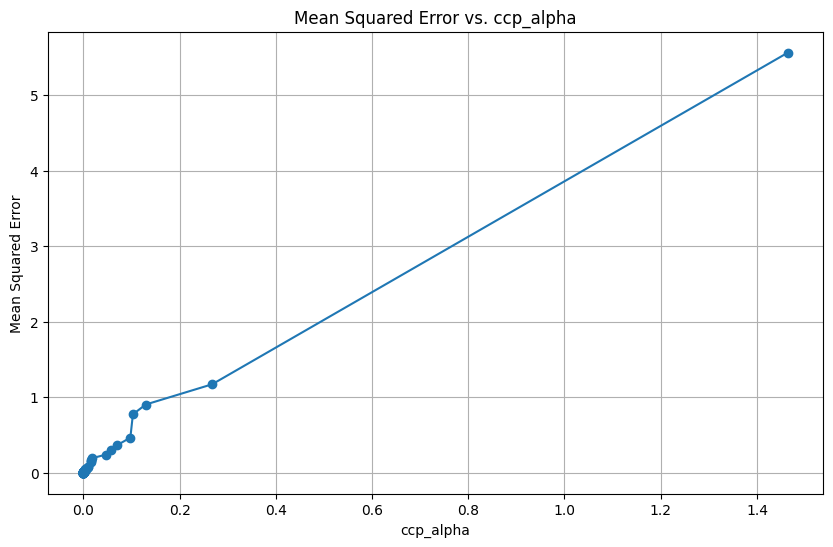

The best ccp_alpha is 0.0 with a mean squared error of 0.0


In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train and y_train are your training data
# Replace these with your actual data
X_train = x_germany
y_train = y_germany

# Use only the first 100 samples
X_train_subset = X_train[:100]
y_train_subset = y_train[:100]

# Train a DecisionTreeRegressor to get the ccp_alphas
model = DecisionTreeRegressor(random_state=0)
path = model.cost_complexity_pruning_path(X_train_subset, y_train_subset)
ccp_alphas = path.ccp_alphas

# Initialize lists to store the alphas and corresponding errors
errors = []

# Loop over the range of ccp_alphas
for ccp_alpha in ccp_alphas:
    # Train the model with the current ccp_alpha
    model = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train_subset, y_train_subset)
    
    # Predict on the training set
    y_pred = model.predict(X_train_subset)
    
    # Calculate the mean squared error
    error = mean_squared_error(y_train_subset, y_pred)
    
    # Append the error to the list
    errors.append(error)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, errors, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. ccp_alpha')
plt.grid(True)
plt.show()

# Find the best ccp_alpha
best_ccp_alpha = ccp_alphas[np.argmin(errors)]
print(f'The best ccp_alpha is {best_ccp_alpha} with a mean squared error of {min(errors)}')

## CART extending window with pruning

In [73]:
x_germany.iloc[[10]]

,tavg,tmin,tmax,wdir,wspd,wpgt,pres,GERMANY_BLOCK_DEMAND_[MW],TOTAL_DEMAND_[MW],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]
10,-0.8,-2.2,0.8,276,12.0,27.8,1028.4,1770,1970,3.47


2


3.4590993622882333

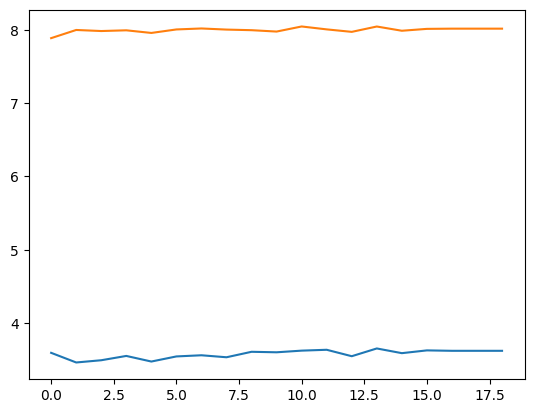

In [104]:
from eval import MAE


X, y = x_austria, y_austria

res = []
for depth in range(1, 20):
    y_pred= []
    for k in range(100, len(X)):
        X_train = X[:k]
        X_valid = X.iloc[[k]]
        y_train = y[:k]
        y_valid = y.iloc[k]
        regressor = DecisionTreeRegressor(random_state=0, max_depth=depth)
        regressor.fit(X_train, y_train)
        y_pred.append(regressor.predict(X_valid))
    # plt.plot(y_germany[100:].values)
    # plt.plot(y_pred)
    # plt.show()
    res.append(MAE(y_pred, y_germany[100:]))
plt.plot(res)
print(np.argmin(res))
np.min(res)



## CART + Ridge

Best ccp_alpha: 1.203493782212662


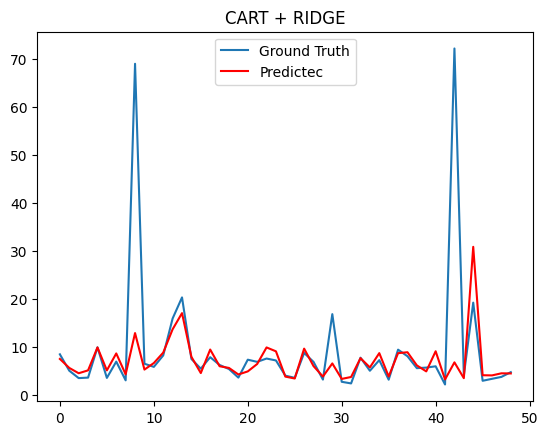

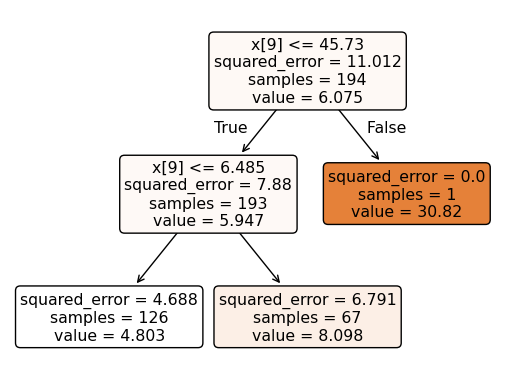

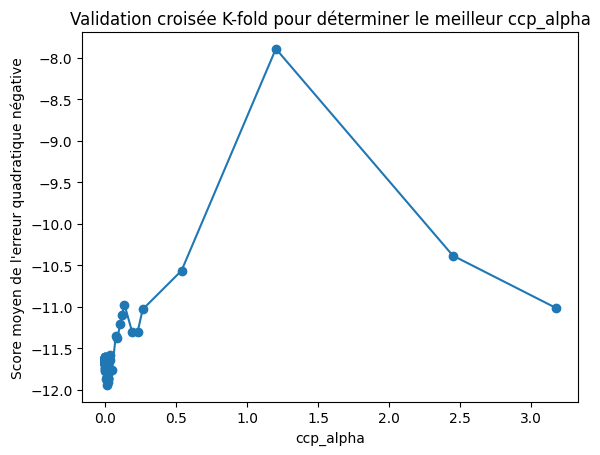

In [46]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

X, y = x_germany, y_germany


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = DecisionTreeRegressor(random_state=0, max_depth=None)
regressor.fit(X_train, y_train)

path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

kf = KFold(n_splits=5, shuffle=True, random_state=0)
mean_scores = []

for ccp_alpha in ccp_alphas:
    regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_scores.append(np.mean(scores))

best_ccp_alpha = ccp_alphas[np.argmax(mean_scores)]
print(f'Best ccp_alpha: {best_ccp_alpha}')

regressor = DecisionTreeRegressor(random_state=0, ccp_alpha=best_ccp_alpha)
regressor.fit(X_train, y_train)

leaf_indices = regressor.apply(X_train)
unique_leaves = np.unique(leaf_indices)

ridge_models = {}

for leaf in unique_leaves:
    indices = np.where(leaf_indices == leaf)
    X_leaf = X_train.iloc[indices]
    y_leaf = y_train.iloc[indices]
    ridge = Ridge()
    ridge.fit(X_leaf, y_leaf)
    ridge_models[leaf] = ridge

leaf_indices_valid = regressor.apply(X_valid)
y_pred = np.zeros_like(y_valid)

for i, leaf in enumerate(leaf_indices_valid):
    ridge = ridge_models[leaf]
    y_pred[i] = ridge.predict(X_valid.iloc[[i]])[0]
    

# Tracer les valeurs réelles et les prédictions
plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='Predictec')
plt.title('CART + RIDGE')
plt.legend()
plt.show()

# Visualiser l'arbre de régression
from sklearn.tree import plot_tree

plot_tree(regressor, filled=True, rounded=True)
plt.show()

plt.plot(ccp_alphas, mean_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Score moyen de l\'erreur quadratique négative')
plt.title('Validation croisée K-fold pour déterminer le meilleur ccp_alpha')
plt.show()

In [ ]:
from eval import MAE


X, y = x_austria, y_austria


y_pred= []
for k in range(100, len(X)):
    X_train = X[:k]
    X_valid = X.iloc[[k]]
    y_train = y[:k]
    y_valid = y.iloc[k]
    regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
    regressor.fit(X_train, y_train)

    leaf_indices = regressor.apply(X_train)
    unique_leaves = np.unique(leaf_indices)

    ridge_models = {}

    for leaf in unique_leaves:
        indices = np.where(leaf_indices == leaf)
        X_leaf = X_train.iloc[indices]
        y_leaf = y_train.iloc[indices]
        ridge = Ridge()
        ridge.fit(X_leaf, y_leaf)
        ridge_models[leaf] = ridge
    
    y_pred.append(ridge_models[regressor.apply(X_valid)[0]].predict(X_valid))
    # y_pred.append(regressor.predict(X_valid)[0])


(2.4291547703617167, 3.1843627300814)
(1274.0913010120203, 1075.1030921005663)


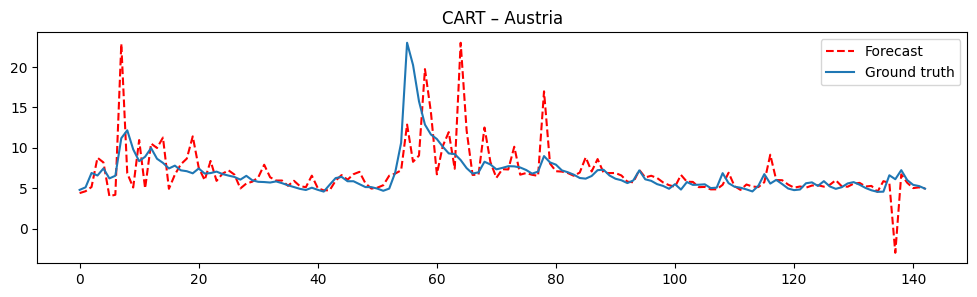

In [158]:
from eval import custom_metric

fig, ax = plt.subplots(figsize=(12, 3))

# Calculate and print metrics
print(MAE(y_pred, y[100:]))
print(custom_metric(y_pred, y[100:], country="Austria"))

# Plot the data
ax.plot(y_pred, label="Forecast", linestyle="--", color="red")
ax.plot(y.values[100:], label="Ground truth")
ax.set_title("CART – Austria")
# Add legend
ax.legend()
plt.savefig("CART.png", dpi=300)

# Show plot
plt.show()


In [25]:
y_pred,y_valid

(array([ 6.1095395 ,  4.95720497,  3.42820796,  4.89618567,  9.64472797,
         4.60175538,  9.6585877 ,  3.91392571, 12.03627661,  5.61490685,
         5.10206074,  7.79483617, 18.93219845, 23.67180673,  7.66680739,
         5.50228916,  8.03423149,  6.14163485,  6.52566172,  3.24112164,
         4.4541781 ,  6.42460909,  8.46993604,  9.26800747,  3.95549705,
         3.81681384,  8.47449887,  6.03321003,  4.28428182,  5.37191976,
         2.87573163,  2.55311439,  7.01131064,  5.71686117,  9.38918448,
         3.51075142, 10.56478166,  8.56507084,  5.72128354,  5.21518675,
         8.73158859,  2.10503912,  6.33234022,  3.11491028, 30.82      ,
         3.52403189,  3.96504919,  3.8667499 ,  4.60625162]),
 110     8.40
 150     4.98
 37      3.44
 75      3.54
 109     9.86
 71      3.48
 122     6.88
 73      2.97
 154    69.00
 234     6.44
 223     5.78
 180     8.17
 157    15.87
 156    20.27
 188     7.43
 135     5.40
 187     7.80
 130     6.18
 224     5.33
 8       3.54
 

In [26]:
df_results[(df_results["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"]>0) & (df_results["PRODUCT"] == "POS_00_04")]["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"].mean()

NameError: name 'df_results' is not defined

In [ ]:
from eval import MSE, custom_metric

(161.676795991205, 757.2195614009745)

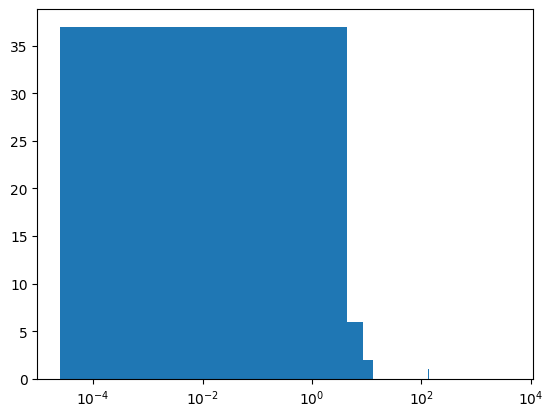

In [12]:
MSE(y_pred, y_valid)

In [13]:
def custom_metric(y_pred, y_true, a=36.97, C =177.69):
    "Return the average loss in € for Germany"
    # a = df_results[(df_results["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"]>0) & (df_results["PRODUCT"] == "POS_00_04")]["GERMANY_IMPORT(-)_EXPORT(+)_[MW]"].mean()
    # C = a*avg_cap_price --> you lost all
    y_t = np.array(y_true)
    y_p= np.array(y_pred)
    loss = (a*np.maximum(y_t-y_p, 0) + a*y_p*(y_t-y_p<0)).mean()*4. #*4 because it lasts 4hours.
    return loss


In [14]:
36*y_pred*(y_valid-y_pred <0)

110       0.000000
150       0.000000
37        0.000000
75      176.262684
109       0.000000
71      165.663194
122     347.709157
73      140.901326
154       0.000000
234       0.000000
223       0.000000
180       0.000000
157     681.559144
156     852.185042
188     276.005066
135     198.082410
187     289.232334
130       0.000000
224     234.923822
8         0.000000
200       0.000000
145       0.000000
90      304.917697
123     333.648269
5       142.397894
22      137.405298
168       0.000000
222       0.000000
12      154.234146
236       0.000000
55      103.526339
44       91.912118
101       0.000000
83      205.807002
118     338.010641
63      126.387051
162     380.332140
173     308.342550
205     205.966208
134       0.000000
146     314.337189
45        0.000000
106       0.000000
18        0.000000
107    1109.520000
15      126.865148
76      142.741771
7       139.202996
213       0.000000
Name: GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h], dtype: float64

In [15]:
36*np.maximum(y_valid-y_pred, 0)

110      82.456578
150       0.820621
37        0.424514
75        0.000000
109       7.749793
71        0.000000
122       0.000000
73        0.000000
154    2050.694042
234      29.703354
223      24.405813
180      13.505898
157       0.000000
156       0.000000
188       0.000000
135       0.000000
187       0.000000
130       1.381146
224       0.000000
8        10.759621
200     101.729588
145      14.594073
90        0.000000
123       0.000000
5         0.000000
22        0.000000
168       7.758041
222      28.324439
12        0.000000
236     410.690888
55        0.000000
44        0.000000
101      24.792817
83        0.000000
118       0.000000
63        0.000000
162       0.000000
173       0.000000
205       0.000000
134      14.933277
146       0.000000
45        0.178592
106    2370.875752
18       31.863230
107       0.000000
15        0.000000
76        0.000000
7         0.000000
213       2.654942
Name: GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h], dtype: float64

In [24]:
custom_metric(y_pred,y_valid) #Faire *12 *365 pour avoir une idée : ici seulement le prix AFRR, et que pour l'export

1111.4787933618968

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


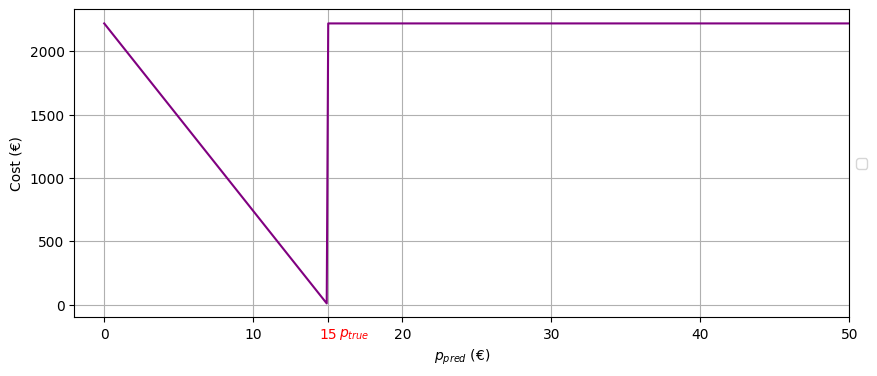

In [ ]:
x = np.linspace(0, 50, 500)
def f(x,p, a= 36.97):
    return (a*np.maximum(p-x, 0) + a*p*(p-x<0))*4.

def S(x, k, p):
    return 1 / (1 + np.exp(-k * (x - p)))

def f_smooth(x, p, k, a = 36.97):
    linear_part = a * np.maximum(p - x, 0)
    constant_part = a * p + a/10*(x-p)
    return 4 * ((1 - S(x, k, p)) * linear_part + S(x, k, p) * constant_part)



fig, ax = plt.subplots(figsize = (10,4))





ax.plot(x, f(x, p=15), color="purple")

# Customize the axes
# ax.spines['left'].set_position('zero')
# ax.spines['left'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['bottom'].set_color('none')

# Add arrows
# ax.annotate('', xy=(0, 0), xytext=(0, 0),
#             arrowprops=dict(arrowstyle="->", color='black'))
# ax.annotate('', xy=(0, 1), xytext=(0, 0),
#             arrowprops=dict(arrowstyle="->", color='black'))

# Add custom tick at p=25
# ax.set_xticklabels([r'$p_{pred} = 25$'])
ax.set_xticks(list(ax.get_xticks()) + [15])
ax.annotate(r'$p_{true}$', xy=(15, 0), xytext=(19, -23),
            textcoords='offset points', ha='center', color='red')

for tick in ax.get_xticklabels():
    if tick.get_text() == '15':
        tick.set_color('red')

for tickline in ax.get_xticklines():
    if tickline.get_xdata()[0] == 15:
        tickline.set_color('red')


# Set labels
ax.set_xbound(-2, 50)
ax.grid(True)
ax.set_xlabel(r"$p_{pred}$ (€/MW/h)")
ax.set_ylabel(r"Cost (€)")

# Add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("cost_loss.png", dpi=300, bbox_inches='tight')

plt.show()
# plt.plot(x, f_smooth(x, p=25, k = 3), color="orange")

In [7]:
def smooth_custom(y_pred, y_true, a = 36.97, k=3):
    p = np.array(y_true)
    x = np.array(y_pred)
    linear_part = a * np.maximum(p - x, 0)
    constant_part = a * p + a/10*(x-p)
    return (4 * ((1 - S(x, k, p)) * linear_part + S(x, k, p) * constant_part)).mean()

In [64]:
smooth_custom(y_pred,y_valid)

1032.0032629025181

In [65]:
custom_metric(y_pred, y_valid)

1168.2882759150725